# **Palmprint Recognition (Image Classification)**
Sumber Dataset: https://www.kaggle.com/datasets/saqibshoaibdz/palmprint100people


## **1. Import Library**
Import semua library yang diperlukan untuk pengolahan data, visualisasi, dan deep learning.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter

plt.style.use('seaborn-v0_8-darkgrid')

## **2. Data Loading**
Fungsi untuk memuat data gambar palmprint dari direktori dan mengorganisir ke dalam array numpy.

In [2]:
def load_data(data_dir):
    images = []
    labels = []
    
    print(f"Memuat gambar dari: {data_dir}")
    
    for label_folder in sorted(os.listdir(data_dir)):
        label_path = os.path.join(data_dir, label_folder)
        
        if not os.path.isdir(label_path):
            continue
            
        label = int(label_folder)
        
        for image_file in sorted(os.listdir(label_path)):
            image_path = os.path.join(label_path, image_file)
            
            image = cv2.imread(image_path)
            
            if image is not None:
                images.append(image)
                labels.append(label)
    
    print(f"Selesai. Total gambar dimuat: {len(images)}")
    return np.array(images), np.array(labels)

base_path = '/kaggle/input/palmprint100people/Palmprint/'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'valid')

X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

Memuat gambar dari: /kaggle/input/palmprint100people/Palmprint/train
Selesai. Total gambar dimuat: 297
Memuat gambar dari: /kaggle/input/palmprint100people/Palmprint/valid
Selesai. Total gambar dimuat: 297


## **3. Data Splitting**
Membagi data test menjadi validation set dan test set baru untuk evaluasi model yang lebih akurat.

In [3]:
X_val, y_val = [], []
X_test_new, y_test_new = [], []

unique_labels_in_test = np.unique(y_test)

for label in unique_labels_in_test:
    indices = np.where(y_test == label)[0]
    
    label_images = X_test[indices]
    label_labels = y_test[indices]
    
    X_val.extend(label_images[:2])
    y_val.extend(label_labels[:2])
    
    X_test_new.extend(label_images[2:])
    y_test_new.extend(label_labels[2:])

X_val = np.array(X_val)
y_val = np.array(y_val)
X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

## **4. Explorasi Data**
Menampilkan informasi dasar tentang dataset termasuk jumlah gambar dan distribusi label.

In [4]:

print("Informasi Data Train")
print(f"Jumlah gambar train: {len(X_train)}")
print(f"Total Subjek/Label Unik: {len(np.unique(y_train))}") 
print(f"Shape dari array gambar train: {X_train.shape}")

print("\nInformasi Data Validasi")
print(f"Jumlah gambar validasi: {len(X_val)}")
print(f"Total Subjek/Label Unik: {len(np.unique(y_val))}")

print("\nInformasi Data Test")
print(f"Jumlah gambar uji: {len(X_test_new)}")
print(f"Total Subjek/Label Unik: {len(np.unique(y_test_new))}")

Informasi Data Train
Jumlah gambar train: 297
Total Subjek/Label Unik: 99
Shape dari array gambar train: (297, 128, 128, 3)

Informasi Data Validasi
Jumlah gambar validasi: 198
Total Subjek/Label Unik: 99

Informasi Data Test
Jumlah gambar uji: 99
Total Subjek/Label Unik: 99


## **5. Visualisasi Data**
Fungsi untuk menampilkan sampel gambar dari dataset untuk label tertentu.

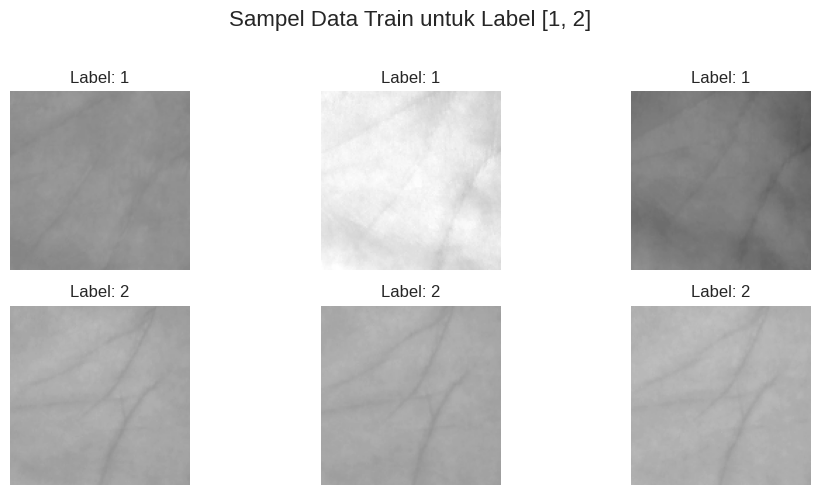

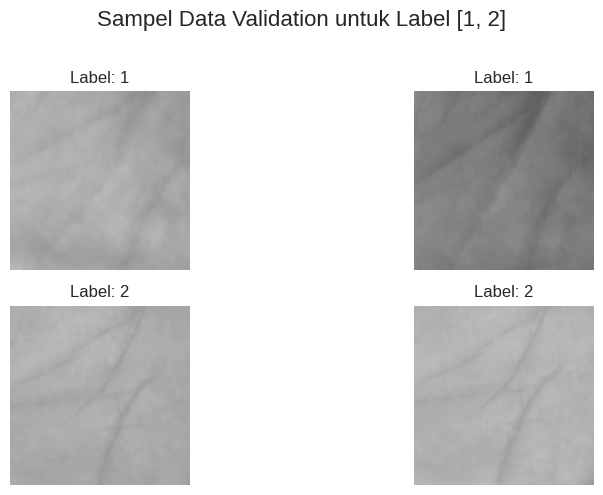

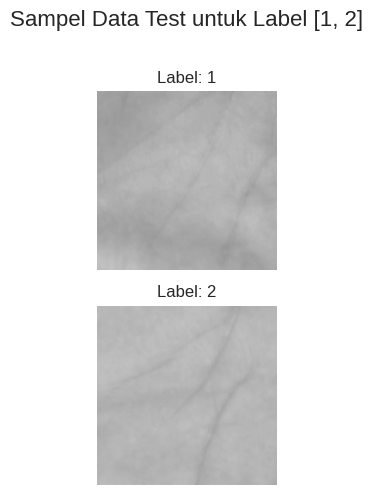

In [5]:
def plot_specific_labels(images, labels, target_labels, dataset_name):
    indices_to_plot = [i for i, label in enumerate(labels) if label in target_labels]
    
    if not indices_to_plot:
        print(f"Tidak ditemukan gambar untuk label {target_labels} di dataset {dataset_name}.")
        return
        
    num_images = len(indices_to_plot)
    cols_per_row = num_images // len(target_labels)
    if cols_per_row == 0: cols_per_row = 1
        
    plt.figure(figsize=(10, 5))
    
    for i, idx in enumerate(indices_to_plot):
        plt.subplot(len(target_labels), cols_per_row, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
        
    plt.suptitle(f'Sampel Data {dataset_name} untuk Label {target_labels}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_specific_labels(X_train, y_train, target_labels=[1, 2], dataset_name="Train")

plot_specific_labels(X_val, y_val, target_labels=[1, 2], dataset_name="Validation")

plot_specific_labels(X_test_new, y_test_new, target_labels=[1, 2], dataset_name="Test")

## **6. Eksperimen Pertama - Baseline CNN Model**

### **6.1 Import Library untuk Deep Learning**
Import library TensorFlow dan Keras untuk membangun model CNN.

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

2025-09-22 01:40:09.193675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758505209.581745      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758505209.685777      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **6.2 Data Preprocessing untuk Model Pertama**
Normalisasi data dan konversi label ke format one-hot encoding.

In [7]:
# Normalisasi
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_new_norm = X_test_new.astype('float32') / 255.0

# One-Hot Encoding
num_classes = np.max(y_train) + 1 
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_new_cat = to_categorical(y_test_new, num_classes=num_classes)

### **6.3 Arsitektur Model CNN Baseline**
Membuat model CNN sederhana dengan 2 layer konvolusi dan 1 layer fully connected.

In [8]:
input_shape = X_train_norm.shape[1:]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758505230.224390      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758505230.225320      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,405,220 (28.25 MB)

 Trainable params: 7,405,220 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

### **6.4 Training Model Pertama**
Compile dan training model dengan 50 epochs menggunakan Adam optimizer.

In [9]:
# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_norm,
    y_train_cat,
    epochs=50,
    # batch_size=32,
    validation_data=(X_val_norm, y_val_cat),
)

Epoch 1/50


I0000 00:00:1758505234.312327      64 service.cc:148] XLA service 0x787a4c003ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758505234.314412      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758505234.314444      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758505234.631908      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0127 - loss: 5.5324

I0000 00:00:1758505238.180545      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - accuracy: 0.0135 - loss: 5.4746 - val_accuracy: 0.0101 - val_loss: 4.6217
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0092 - loss: 4.6268 - val_accuracy: 0.0101 - val_loss: 4.6066
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0129 - loss: 4.6073 - val_accuracy: 0.0101 - val_loss: 4.5955
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0239 - loss: 4.5731 - val_accuracy: 0.0253 - val_loss: 4.5784
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0159 - loss: 4.5088 - val_accuracy: 0.0152 - val_loss: 4.5915
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0308 - loss: 4.4334 - val_accuracy: 0.0152 - val_loss: 4.6397
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0197 - loss: 4.4363 - val_accuracy: 0.0101 - val_loss: 4.7348
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0327 - loss: 4.4510 - val_accuracy: 0.0101 - val_loss: 4

### **6.5 Visualisasi Training History**
Plot kurva training dan validation accuracy serta loss untuk analisis performa model.

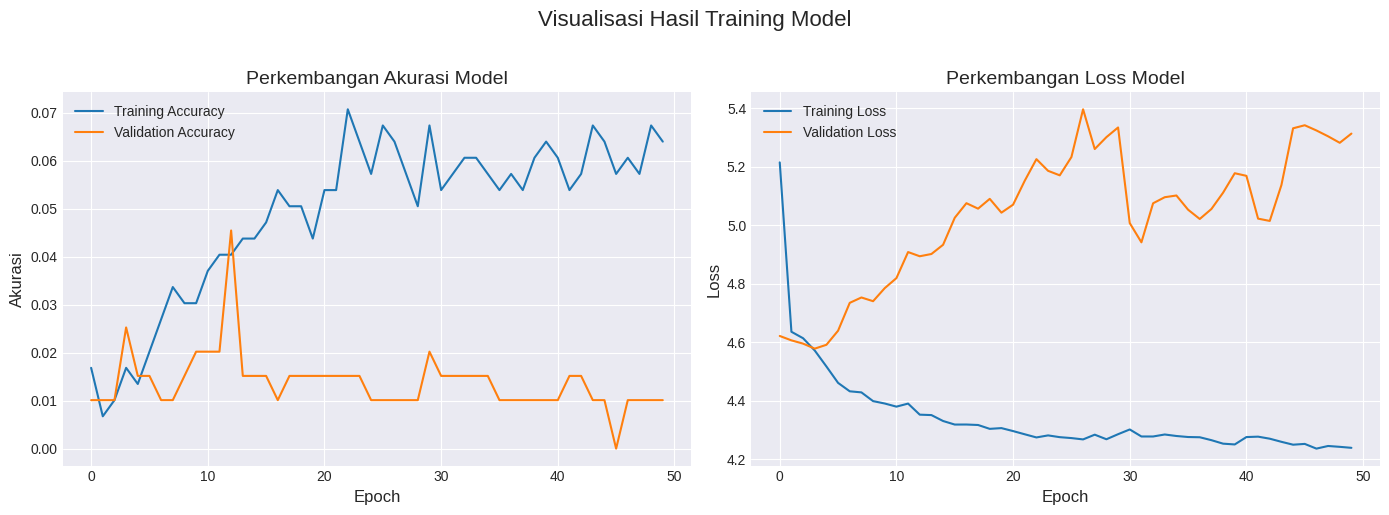

In [10]:
history_df = pd.DataFrame(history.history)

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_df['accuracy'], '-', label='Training Accuracy')
axes[0].plot(history_df['val_accuracy'], '-', label='Validation Accuracy')
axes[0].set_title('Perkembangan Akurasi Model', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Akurasi', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_df['loss'], '-', label='Training Loss')
axes[1].plot(history_df['val_loss'], '-', label='Validation Loss')
axes[1].set_title('Perkembangan Loss Model', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Visualisasi Hasil Training Model', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **6.6 Evaluasi Model Pertama**
Evaluasi performa model menggunakan classification report pada test set.

In [11]:
y_pred_probs = model.predict(X_test_new_norm)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("--- Classification Report ---")
target_names = [f"Subject {i}" for i in np.unique(y_test_new)]

report = classification_report(y_test_new, y_pred_classes, target_names=target_names, zero_division=0)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
--- Classification Report ---
              precision    recall  f1-score   support

   Subject 1       0.00      0.00      0.00         1
   Subject 2       0.00      0.00      0.00         1
   Subject 3       0.00      0.00      0.00         1
   Subject 4       0.00      0.00      0.00         1
   Subject 5       0.00      0.00      0.00         1
   Subject 6       0.00      0.00      0.00         1
   Subject 7       0.00      0.00      0.00         1
   Subject 8       0.00      0.00      0.00         1
   Subject 9       0.00      0.00      0.00         1
  Subject 10       0.00      0.00      0.00         1
  Subject 11       0.00      0.00      0.00         1
  Subject 12       0.00      0.00      0.00         1
  Subject 13       0.00      0.00      0.00         1
  Subject 14       0.00      0.00      0.00         1
  Subject 15       0.00      0.00      0.00         1
  Subject 16       0.00      0.00      0.00         1
  Subject 17

## **7. Eksperimen Kedua (Hyperparameter Tuning)**

### **7.1 Arsitektur Model Kedua**
Model CNN yang sama dengan eksperimen pertama namun dengan hyperparameter yang berbeda.

In [12]:
input_shape = X_train_norm.shape[1:]

model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    # Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,405,220 (28.25 MB)

 Trainable params: 7,405,220 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

### **7.2 Training Model Kedua**
Training model dengan epochs yang lebih banyak (100 epochs) untuk mengeksplorasi konvergensi.

In [13]:
# Kompilasi model
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model_2.fit(
    X_train_norm,
    y_train_cat,
    epochs=100,
    # batch_size=32,
    validation_data=(X_val_norm, y_val_cat),
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.0047 - loss: 5.0817 - val_accuracy: 0.0101 - val_loss: 4.6044
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0084 - loss: 4.6078 - val_accuracy: 0.0152 - val_loss: 4.6045
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0034 - loss: 4.6048 - val_accuracy: 0.0101 - val_loss: 4.6012
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0204 - loss: 4.5717 - val_accuracy: 0.0101 - val_loss: 4.6378
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0057 - loss: 4.5322 - val_accuracy: 0.0101 - val_loss: 4.6101
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0203 - loss: 4.4905 - val_accuracy: 0.0101 - val_loss: 4.6596
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0290 - loss: 4.4242 - val_accuracy: 0.0202 - val_loss: 4.7165
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0539 - loss: 4.4258 - val_accuracy: 0

### **7.3 Visualisasi Training History Model Kedua**
Plot hasil training untuk model dengan epochs yang lebih banyak.

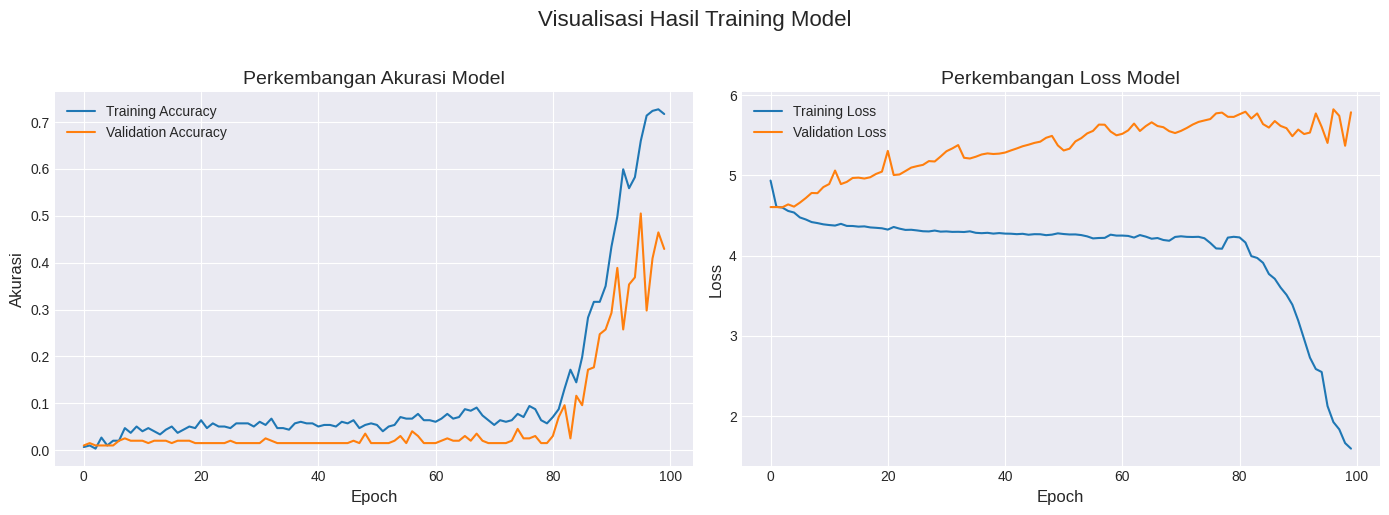

In [14]:
history_df_2 = pd.DataFrame(history_2.history)

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_df_2['accuracy'], '-', label='Training Accuracy')
axes[0].plot(history_df_2['val_accuracy'], '-', label='Validation Accuracy')
axes[0].set_title('Perkembangan Akurasi Model', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Akurasi', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_df_2['loss'], '-', label='Training Loss')
axes[1].plot(history_df_2['val_loss'], '-', label='Validation Loss')
axes[1].set_title('Perkembangan Loss Model', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Visualisasi Hasil Training Model', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **7.4 Evaluasi Model Kedua**
Evaluasi performa model kedua untuk membandingkan dengan baseline.

In [15]:
y_pred_probs = model_2.predict(X_test_new_norm)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("--- Classification Report ---")
target_names = [f"Subject {i}" for i in np.unique(y_test_new)]

report = classification_report(y_test_new, y_pred_classes, target_names=target_names, zero_division=0)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
--- Classification Report ---
              precision    recall  f1-score   support

   Subject 1       0.00      0.00      0.00         1
   Subject 2       0.00      0.00      0.00         1
   Subject 3       0.25      1.00      0.40         1
   Subject 4       0.00      0.00      0.00         1
   Subject 5       0.00      0.00      0.00         1
   Subject 6       0.00      0.00      0.00         1
   Subject 7       0.00      0.00      0.00         1
   Subject 8       0.00      0.00      0.00         1
   Subject 9       0.00      0.00      0.00         1
  Subject 10       0.00      0.00      0.00         1
  Subject 11       0.00      0.00      0.00         1
  Subject 12       0.00      0.00      0.00         1
  Subject 13       0.00      0.00      0.00         1
  Subject 14       0.17      1.00      0.29         1
  Subject 15       0.00      0.00      0.00         1
  Subject 16       1.00      1.00      1.00         1
  Subject 17 

## **8. Eksperimen Ketiga (Image Preprocessing)**

### **8.1 Data Loading dengan Grayscale**
Memuat ulang data dengan konversi ke grayscale untuk mengurangi kompleksitas dan fokus pada tekstur palmprint.

In [16]:
def load_data(data_dir):
    images = []
    labels = []
    
    print(f"Memuat gambar dari: {data_dir}")
    
    for label_folder in sorted(os.listdir(data_dir)):
        label_path = os.path.join(data_dir, label_folder)
        
        if not os.path.isdir(label_path):
            continue
            
        label = int(label_folder)
        
        for image_file in sorted(os.listdir(label_path)):
            image_path = os.path.join(label_path, image_file)
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                images.append(image)
                labels.append(label)
    
    print(f"Selesai. Total gambar dimuat: {len(images)}")
    return np.array(images), np.array(labels)

base_path = '/kaggle/input/palmprint100people/Palmprint/'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'valid')

X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

Memuat gambar dari: /kaggle/input/palmprint100people/Palmprint/train
Selesai. Total gambar dimuat: 297
Memuat gambar dari: /kaggle/input/palmprint100people/Palmprint/valid
Selesai. Total gambar dimuat: 297


### **8.2 Data Splitting untuk Eksperimen Ketiga**
Membagi ulang data grayscale menjadi train, validation, dan test set.

In [17]:
X_val, y_val = [], []
X_test_new, y_test_new = [], []

unique_labels_in_test = np.unique(y_test)

for label in unique_labels_in_test:
    indices = np.where(y_test == label)[0]
    label_images = X_test[indices]
    label_labels = y_test[indices]
    
    X_val.extend(label_images[:2])
    y_val.extend(label_labels[:2])
    
    X_test_new.extend(label_images[2:])
    y_test_new.extend(label_labels[2:])

X_val = np.array(X_val)
y_val = np.array(y_val)
X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(f"Bentuk data validasi baru: {X_val.shape}")
print(f"Bentuk data tes baru: {X_test_new.shape}")

Bentuk data validasi baru: (198, 128, 128)
Bentuk data tes baru: (99, 128, 128)


### **8.3 CLAHE (Contrast Limited Adaptive Histogram Equalization)**
Menerapkan CLAHE untuk meningkatkan kontras dan detail pada gambar palmprint.

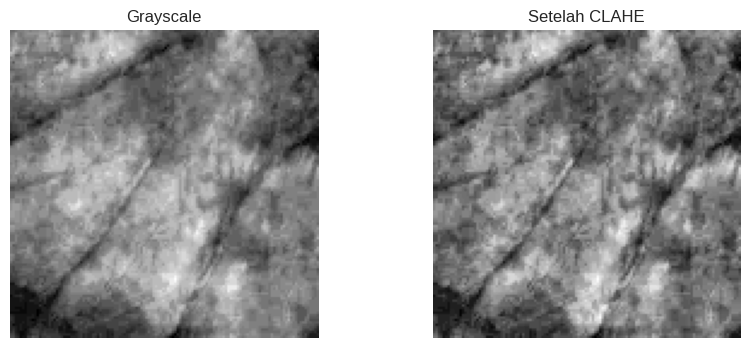

In [18]:
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    processed_images = []
    for img in images:
        clahe_img = clahe.apply(img)
        processed_images.append(clahe_img)
        
    return np.array(processed_images)

X_train_clahe = apply_clahe(X_train)
X_val_clahe = apply_clahe(X_val)
X_test_new_clahe = apply_clahe(X_test_new)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title("Grayscale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_train_clahe[0], cmap='gray')
plt.title("Setelah CLAHE")
plt.axis('off')
plt.show()

### **8.4 Preprocessing untuk Model Grayscale**
Normalisasi dan reshape data grayscale untuk input ke CNN.

In [19]:
X_train_norm = X_train_clahe.astype('float32') / 255.0
X_val_norm = X_val_clahe.astype('float32') / 255.0
X_test_new_norm = X_test_new_clahe.astype('float32') / 255.0

X_train_reshaped = np.expand_dims(X_train_norm, axis=-1)
X_val_reshaped = np.expand_dims(X_val_norm, axis=-1)
X_test_new_reshaped = np.expand_dims(X_test_new_norm, axis=-1)

num_classes = np.max(y_train) + 1 
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_new_cat = to_categorical(y_test_new, num_classes=num_classes)

print("Bentuk data latih setelah reshape:", X_train_reshaped.shape)

Bentuk data latih setelah reshape: (297, 128, 128, 1)


### **8.5 Model CNN untuk Grayscale**
Arsitektur CNN yang disesuaikan untuk input grayscale (single channel).

In [20]:
input_shape = X_train_reshaped.shape[1:]

model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    # Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_3.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_3 = model_3.fit(
    X_train_reshaped, 
    y_train_cat,
    epochs=50,
    # batch_size=32,
    validation_data=(X_val_reshaped, y_val_cat),
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.0103 - loss: 4.9284 - val_accuracy: 0.0101 - val_loss: 4.6046
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0073 - loss: 4.6052 - val_accuracy: 0.0152 - val_loss: 4.6025
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0088 - loss: 4.5972 - val_accuracy: 0.0101 - val_loss: 4.5911
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0306 - loss: 4.5515 - val_accuracy: 0.0101 - val_loss: 4.5682
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0311 - loss: 4.4930 - val_accuracy: 0.0253 - val_loss: 4.5646
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0674 - loss: 4.3564 - val_accuracy: 0.0253 - val_loss: 4.5593
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0956 - loss: 4.1944 - val_accuracy: 0.0404 - val_loss: 4.5699
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1101 - loss: 4.1171 - val_accuracy: 0.0960 - val_loss: 4

### **8.6 Visualisasi Training Model Ketiga**
Plot hasil training untuk model dengan preprocessing CLAHE.

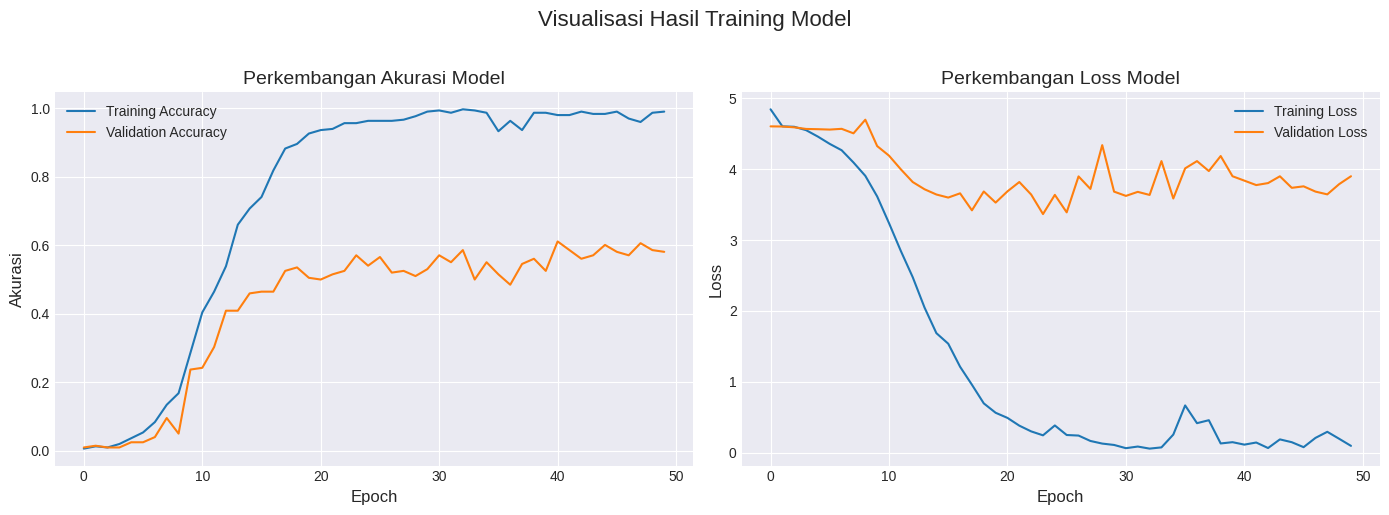

In [21]:
history_df_3 = pd.DataFrame(history_3.history)

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_df_3['accuracy'], '-', label='Training Accuracy')
axes[0].plot(history_df_3['val_accuracy'], '-', label='Validation Accuracy')
axes[0].set_title('Perkembangan Akurasi Model', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Akurasi', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_df_3['loss'], '-', label='Training Loss')
axes[1].plot(history_df_3['val_loss'], '-', label='Validation Loss')
axes[1].set_title('Perkembangan Loss Model', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Visualisasi Hasil Training Model', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **8.7 Evaluasi Model Ketiga**
Evaluasi performa model dengan preprocessing CLAHE.

In [22]:
y_pred_probs = model_3.predict(X_test_new_norm)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("--- Classification Report ---")
target_names = [f"Subject {i}" for i in np.unique(y_test_new)]

report = classification_report(y_test_new, y_pred_classes, target_names=target_names, zero_division=0)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
--- Classification Report ---
              precision    recall  f1-score   support

   Subject 1       0.00      0.00      0.00         1
   Subject 2       0.00      0.00      0.00         1
   Subject 3       0.50      1.00      0.67         1
   Subject 4       0.50      1.00      0.67         1
   Subject 5       0.00      0.00      0.00         1
   Subject 6       0.00      0.00      0.00         1
   Subject 7       0.00      0.00      0.00         1
   Subject 8       0.50      1.00      0.67         1
   Subject 9       0.00      0.00      0.00         1
  Subject 10       0.00      0.00      0.00         1
  Subject 11       0.50      1.00      0.67         1
  Subject 12       0.00      0.00      0.00         1
  Subject 13       0.00      0.00      0.00         1
  Subject 14       0.50      1.00      0.67         1
  Subject 15       1.00      1.00      1.00         1
  Subject 16       0.33      1.00      0.50         1
  Subject 17

### **9. Eksperimen Keempat (Transfer Learning)**

### **9.1 Data Preprocessing untuk Transfer Learning**
Konversi data grayscale ke format RGB dan preprocessing untuk model pre-trained.

In [23]:
X_train_rgb = np.stack([X_train_clahe]*3, axis=-1)
X_val_rgb = np.stack([X_val_clahe]*3, axis=-1)
X_test_new_rgb = np.stack([X_test_new_clahe]*3, axis=-1)

X_train_processed = tf.keras.applications.mobilenet_v3.preprocess_input(X_train_rgb)
X_val_processed = tf.keras.applications.mobilenet_v3.preprocess_input(X_val_rgb)
X_test_new_processed = tf.keras.applications.mobilenet_v3.preprocess_input(X_test_new_rgb)

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_new_cat = to_categorical(y_test_new, num_classes=num_classes)

print("Bentuk data latih setelah diubah ke format RGB:", X_train_processed.shape)

Bentuk data latih setelah diubah ke format RGB: (297, 128, 128, 3)


### **9.2 Transfer Learning dengan MobileNetV3**
Menggunakan MobileNetV3 pre-trained sebagai feature extractor dengan custom classifier.

In [24]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = tf.keras.applications.MobileNetV3Large(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_4 = Model(inputs=base_model.input, outputs=predictions)

model_4.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 64, 64,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 64, 64,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 64, 64,    │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 64, 64,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 64, 64,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 65, 65,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 32, 32,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 32, 32,    │        256 │ expanded_conv_1_

 Total params: 3,132,260 (11.95 MB)

 Trainable params: 135,908 (530.89 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

### **9.3 Training Transfer Learning Model**
Training model dengan frozen pre-trained layers untuk transfer learning.

In [25]:

history_4 = model_4.fit(
    X_train_processed, 
    y_train_cat,
    epochs=25,
    # batch_size=32,
    validation_data=(X_val_processed, y_val_cat),
)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0025 - loss: 4.9310 - val_accuracy: 0.0657 - val_loss: 4.4800
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0716 - loss: 4.3275 - val_accuracy: 0.1061 - val_loss: 4.2398
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2120 - loss: 3.9814 - val_accuracy: 0.1818 - val_loss: 3.9717
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2654 - loss: 3.6967 - val_accuracy: 0.3030 - val_loss: 3.6820
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4743 - loss: 3.1994 - val_accuracy: 0.4040 - val_loss: 3.3664
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6091 - loss: 2.7626 - val_accuracy: 0.4899 - val_loss: 3.0280
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7429 - loss: 2.3180 - val_accuracy: 0.5455 - val_loss: 2.7223
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8362 - loss: 1.9705 - val_accuracy: 0.6010 - va

### **9.4 Visualisasi Training Transfer Learning**
Plot hasil training untuk model transfer learning.

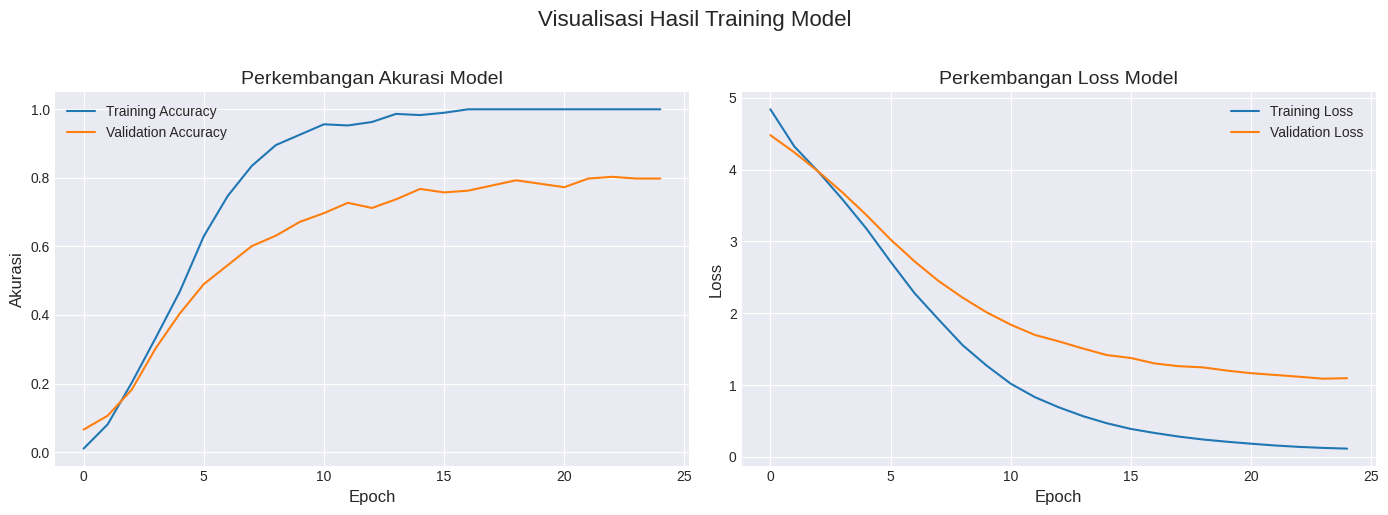

In [26]:
history_df_4 = pd.DataFrame(history_4.history)

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_df_4['accuracy'], '-', label='Training Accuracy')
axes[0].plot(history_df_4['val_accuracy'], '-', label='Validation Accuracy')
axes[0].set_title('Perkembangan Akurasi Model', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Akurasi', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_df_4['loss'], '-', label='Training Loss')
axes[1].plot(history_df_4['val_loss'], '-', label='Validation Loss')
axes[1].set_title('Perkembangan Loss Model', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Visualisasi Hasil Training Model', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **9.5 Evaluasi Transfer Learning Model**
Evaluasi performa final dari model transfer learning.

In [27]:
y_pred_probs = model_4.predict(X_test_new_processed)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("--- Classification Report (Eksperimen 4) ---")
target_names = [f"Subject {i}" for i in np.unique(y_test_new)]

report = classification_report(y_test_new, y_pred_classes, target_names=target_names, zero_division=0)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
--- Classification Report (Eksperimen 4) ---
              precision    recall  f1-score   support

   Subject 1       0.00      0.00      0.00         1
   Subject 2       1.00      1.00      1.00         1
   Subject 3       1.00      1.00      1.00         1
   Subject 4       1.00      1.00      1.00         1
   Subject 5       0.00      0.00      0.00         1
   Subject 6       0.50      1.00      0.67         1
   Subject 7       0.00      0.00      0.00         1
   Subject 8       1.00      1.00      1.00         1
   Subject 9       0.50      1.00      0.67         1
  Subject 10       0.00      0.00      0.00         1
  Subject 11       1.00      1.00      1.00         1
  Subject 12       0.33      1.00      0.50         1
  Subject 13       1.00      1.00      1.00         1
  Subject 14       1.00      1.00      1.00         1
  Subject 15       0.50      1.00      0.67         1
  Subject 16       1.00      1.00      1.00         1